# EDA OF MENTAL HEALTH IN TECH INDUSTRY SURVEY 

In [1]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import binom
from collections import Counter
conn = sqlite3.connect('mental_health.sqlite')
%load_ext sql
%sql sqlite:///mental_health.sqlite


## Creating Dataset from Database

In [2]:
%%sql
CREATE TABLE CombinedTable AS
SELECT 
    a.AnswerText,
    a.SurveyID,
    a.UserID,
    a.QuestionID,
    q.questiontext AS QuestionText,
    s.Description AS SurveyDescription
FROM Answer a
JOIN Question q ON a.QuestionID = q.questionid
JOIN Survey s ON a.SurveyID = s.SurveyID;


 * sqlite:///mental_health.sqlite
(sqlite3.OperationalError) table CombinedTable already exists
[SQL: CREATE TABLE CombinedTable AS
SELECT 
    a.AnswerText,
    a.SurveyID,
    a.UserID,
    a.QuestionID,
    q.questiontext AS QuestionText,
    s.Description AS SurveyDescription
FROM Answer a
JOIN Question q ON a.QuestionID = q.questionid
JOIN Survey s ON a.SurveyID = s.SurveyID;]
(Background on this error at: https://sqlalche.me/e/20/e3q8)


## Investigate Dataset

In [3]:
# List all tables in the database
tables = pd.read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", conn)
print(tables)

# Verify the structure of the CombinedTable
table_structure = pd.read_sql_query("PRAGMA table_info(CombinedTable);", conn)
print(table_structure)


            name
0         Answer
1       Question
2         Survey
3  CombinedTable
   cid               name  type  notnull dflt_value  pk
0    0         AnswerText  TEXT        0       None   0
1    1           SurveyID   INT        0       None   0
2    2             UserID   INT        0       None   0
3    3         QuestionID   INT        0       None   0
4    4       QuestionText  TEXT        0       None   0
5    5  SurveyDescription  TEXT        0       None   0


In [4]:
# Query the first few rows from the CombinedTable
combined_table_preview = pd.read_sql_query("SELECT * FROM CombinedTable LIMIT 5;", conn)
print(combined_table_preview)


  AnswerText  SurveyID  UserID  QuestionID       QuestionText  \
0         37      2014       1           1  What is your age?   
1         44      2014       2           1  What is your age?   
2         32      2014       3           1  What is your age?   
3         31      2014       4           1  What is your age?   
4         31      2014       5           1  What is your age?   

               SurveyDescription  
0  mental health survey for 2014  
1  mental health survey for 2014  
2  mental health survey for 2014  
3  mental health survey for 2014  
4  mental health survey for 2014  


## Loading and Cleaning Dataset

In [5]:
df = pd.read_sql_query("SELECT * FROM CombinedTable;", conn)

# Close the database connection
conn.close()

# Display the first few rows of the DataFrame
df.head(10)

,AnswerText,SurveyID,UserID,QuestionID,QuestionText,SurveyDescription
0,37,2014,1,1,What is your age?,mental health survey for 2014
1,44,2014,2,1,What is your age?,mental health survey for 2014
2,32,2014,3,1,What is your age?,mental health survey for 2014
3,31,2014,4,1,What is your age?,mental health survey for 2014
4,31,2014,5,1,What is your age?,mental health survey for 2014
5,33,2014,6,1,What is your age?,mental health survey for 2014
6,35,2014,7,1,What is your age?,mental health survey for 2014
7,39,2014,8,1,What is your age?,mental health survey for 2014
8,42,2014,9,1,What is your age?,mental health survey for 2014
9,23,2014,10,1,What is your age?,mental health survey for 2014


In [6]:
df.isnull().sum()

AnswerText           0
SurveyID             0
UserID               0
QuestionID           0
QuestionText         0
SurveyDescription    0
dtype: int64

In [7]:
df.drop_duplicates(inplace=True)

## Overview of Respondents

### Sample size

In [8]:
sample_size = df['UserID'].nunique()
print(f"Sample Size: {sample_size}")


Sample Size: 4218


### Sociodemographic Features

In [9]:
# Sociodemograohic Features
demographic_keywords = ['age', 'gender', 'race', 'education', 'income', 'country', 'state']
demographic_questions = df[df['QuestionText'].str.contains('|'.join(demographic_keywords), case=False, na=False)]

demographic_questions['QuestionText'].unique()


array(['What is your age?', 'What is your gender?',
       'What country do you live in?',
       'If you live in the United States, which state or territory do you live in?',
       'Does your employer provide mental health benefits as part of healthcare coverage?',
       'Is your anonymity protected if you choose to take advantage of mental health or substance abuse treatment resources provided by your employer?',
       'Do you know the options for mental health care available under your employer-provided health coverage?',
       'Do you have medical coverage (private insurance or state-provided) that includes treatment of mental health disorders?',
       'Was your anonymity protected if you chose to take advantage of mental health or substance abuse treatment resources with previous employers?',
       'What country do you work in?',
       'What US state or territory do you work in?',
       'If yes, what percentage of your work time (time performing primary or secondary job fu

## Sociodemographic Analysis

### Age Distribution

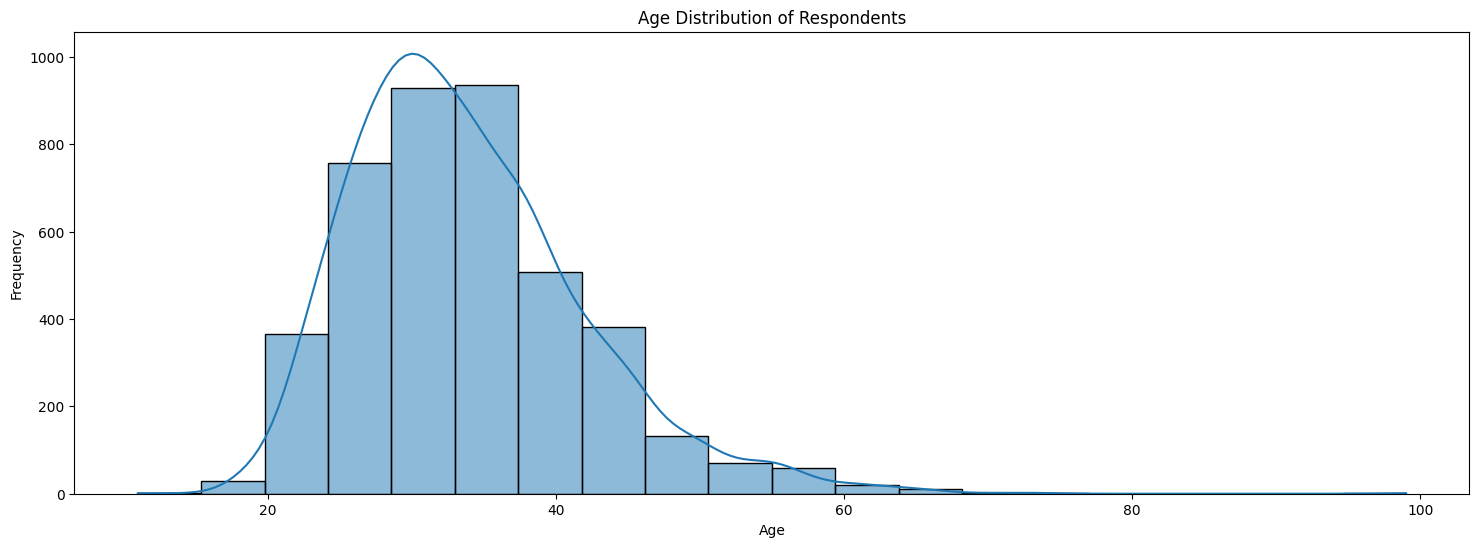

In [10]:

age_df = df[df['QuestionText'].str.contains('age', case=False, na=False)].copy()

age_df.loc[:, 'Age'] = pd.to_numeric(age_df['AnswerText'], errors='coerce')

# Remove unrealistic ages
age_df = age_df[(age_df['Age'] > 10) & (age_df['Age'] < 100)]

plt.figure(figsize=(18, 6))
sns.histplot(age_df['Age'], bins=20, kde=True)
plt.title('Age Distribution of Respondents')
plt.xlabel('Age')
plt.ylabel('Frequency')
plt.show()




### Gender Distribution

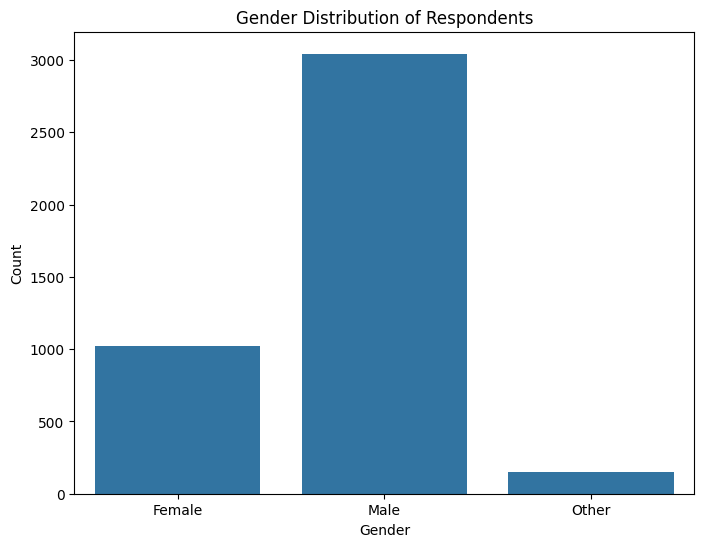

In [11]:
gender_df = df[df['QuestionText'].str.contains('gender', case=False, na=False)].copy()
gender_df['Gender'] = gender_df['AnswerText'].str.strip().str.lower()

def categorize_gender(gender):
    if gender in ['male', 'm', 'man']:
        return 'Male'
    elif gender in ['female', 'f', 'woman']:
        return 'Female'
    else:
        return 'Other'

gender_df['Gender_Cat'] = gender_df['Gender'].apply(categorize_gender)

plt.figure(figsize=(8, 6))
sns.countplot(x='Gender_Cat', data=gender_df)
plt.title('Gender Distribution of Respondents')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.show()


### Geographic Distribution

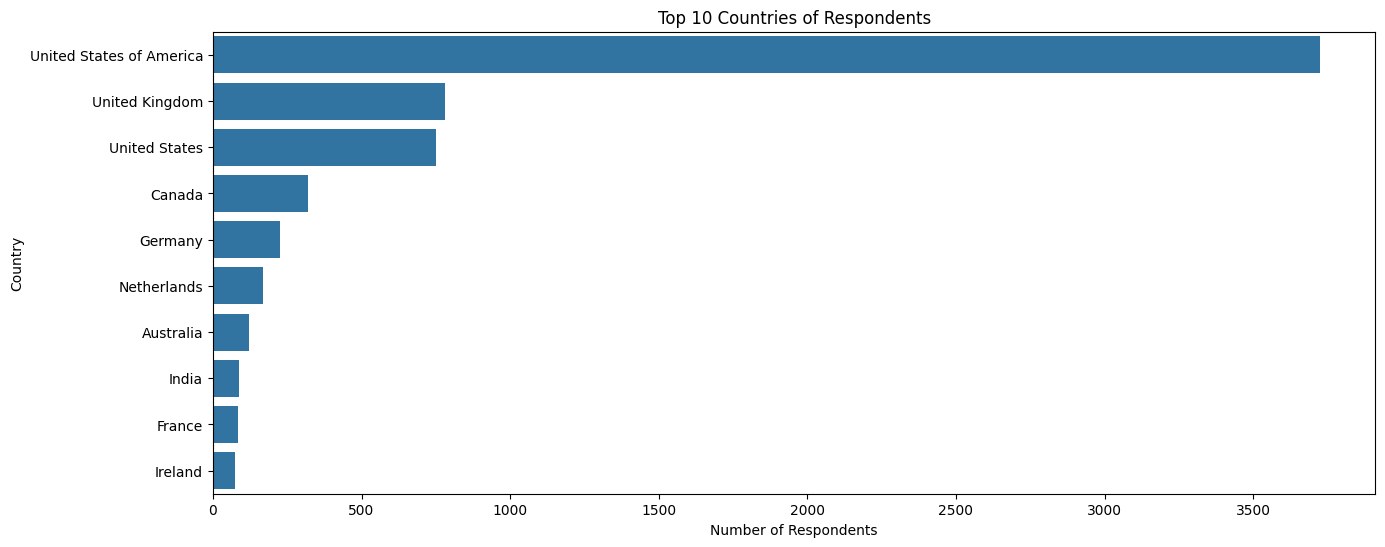

In [12]:
country_df = df[df['QuestionText'].str.contains('country', case=False, na=False)]

top_countries = country_df['AnswerText'].value_counts().nlargest(10)


plt.figure(figsize=(15, 6))
sns.barplot(x=top_countries.values, y=top_countries.index)
plt.title('Top 10 Countries of Respondents')
plt.xlabel('Number of Respondents')
plt.ylabel('Country')
plt.show()


### Sampling Bias

From the Sociodemograpic analysis above observe a sampling bias in the gender and geographical distributions as the number of male interviewees is tripple that of the female and other genders. Also majority of the respondents were from the USA far more than any other country. 

It can be very hard to make accurate conclusions based on a biased sample as it leans into one demograpihic and doesn't offer diverse insight

## Question Analysis

### A. Workplace Support and Stigma

Sample Question:
"Do you think that discussing a mental health disorder with your employer would have negative consequences?"

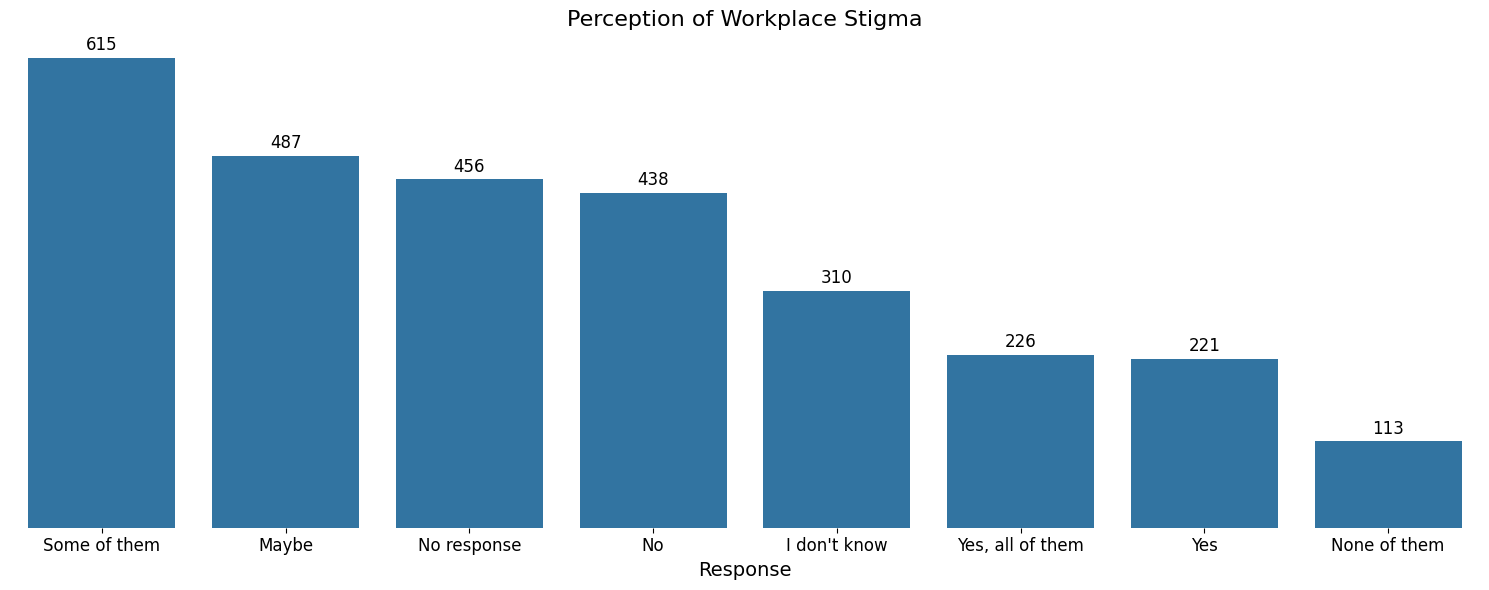

In [13]:
workplace_stigma = df.loc[df['QuestionText'].str.contains('discussing a mental health disorder.*employer.*negative consequences', case=False, na=False)]

workplace_stigma.loc[:, 'AnswerText'] = workplace_stigma['AnswerText'].astype(str).replace('-1', 'No response')

response_counts = workplace_stigma['AnswerText'].value_counts()

plt.figure(figsize=(15, 6))
ax = sns.barplot(x=response_counts.index, y=response_counts.values)

for i, v in enumerate(response_counts.values):
    ax.text(i, v + 10, str(v), ha='center', fontsize=12)

plt.title("Perception of Workplace Stigma", fontsize=16)
plt.xlabel("Response", fontsize=14)
plt.xticks(fontsize=12)
plt.gca().axes.yaxis.set_visible(False)
plt.tight_layout()
sns.despine(left=True, bottom=True)
plt.show()


According to the survey, many people with mental health issues believe that more often than not they will be percieved differently by co-workers and employers due to the fact.

This is the kind of interaction that would affect them being open about accpeting help, discussing or even sharing struggles with mental health. 

#### Stigma effect on treatment seeking

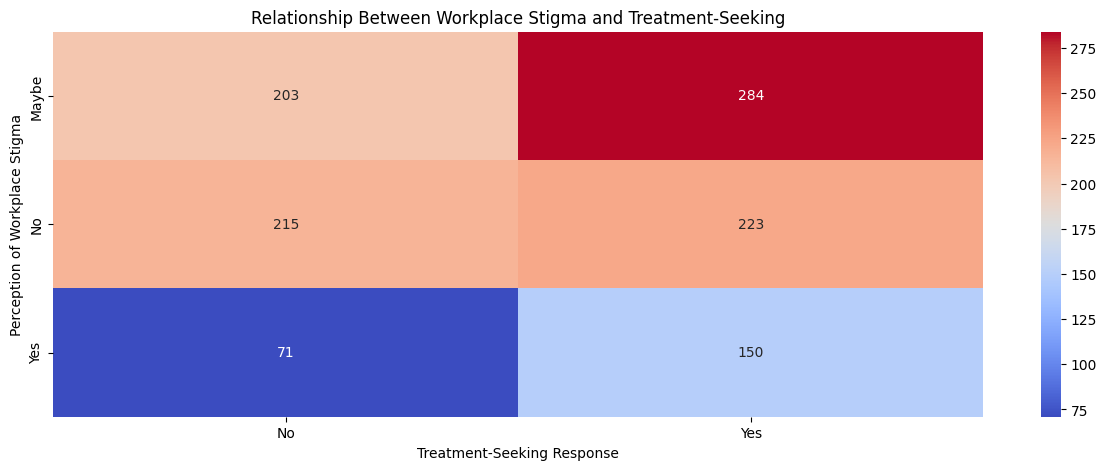

In [14]:
stigma_treatment = df[df['QuestionText'].isin([
    "Do you think that discussing a mental health disorder with your employer would have negative consequences?",
    "Have you ever sought treatment for a mental health disorder from a mental health professional?"
])]

stigma_treatment.loc[stigma_treatment['AnswerText'] == '1', 'AnswerText'] = 'Yes'
stigma_treatment.loc[stigma_treatment['AnswerText'] == '0', 'AnswerText'] = 'No'
stigma_treatment = stigma_treatment.loc[stigma_treatment['AnswerText'] != '-1']


stigma_treatment_pivot = stigma_treatment.pivot(index='UserID', columns='QuestionText', values='AnswerText')

cross_tab = pd.crosstab(stigma_treatment_pivot.iloc[:, 0], stigma_treatment_pivot.iloc[:, 1])

plt.figure(figsize=(15, 5))
sns.heatmap(cross_tab, annot=True, fmt='d', cmap='coolwarm')
plt.title("Relationship Between Workplace Stigma and Treatment-Seeking")
plt.xlabel("Treatment-Seeking Response")
plt.ylabel("Perception of Workplace Stigma")
plt.show()


Workplaces with percieved stigma towards mental health disorders have lower numbers of treatment seeking individuals. 

It is therefore vital to destigmatize workplaces to create a healthier environment for workers with mental health disorders.

### B. Treatment Seeking Behavior

Sample Question:
"Have you ever sought treatment for a mental health disorder from a mental health professional?"

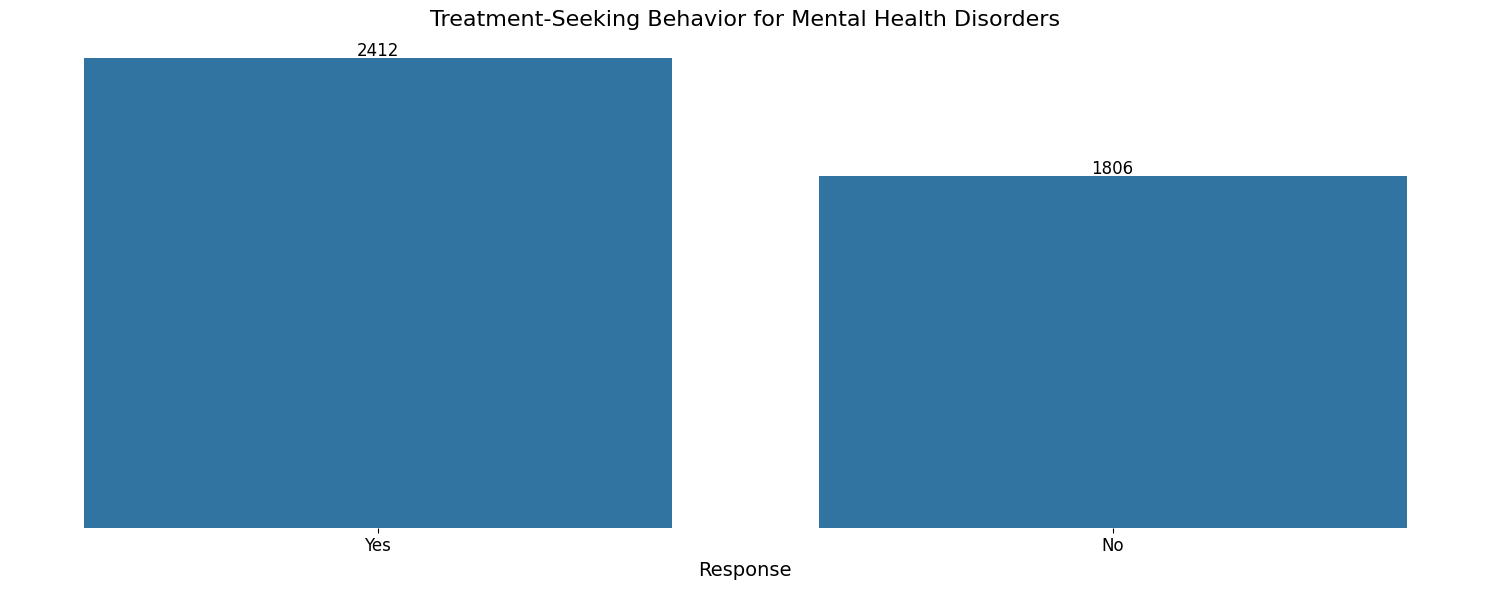

In [15]:
treatment_seeking = df[df['QuestionText'].str.contains('sought treatment.*mental health professional', case=False, na=False)]

treatment_seeking.loc[treatment_seeking['AnswerText'] == '1', 'AnswerText'] = 'Yes'
treatment_seeking.loc[treatment_seeking['AnswerText'] == '0', 'AnswerText'] = 'No'

treatment_counts = treatment_seeking['AnswerText'].value_counts()

plt.figure(figsize=(15, 6))
ax = sns.barplot(x=treatment_counts.index, y=treatment_counts.values)

for i, v in enumerate(treatment_counts.values):
    ax.text(i, v + 10, str(v), ha='center', fontsize=12)


plt.title("Treatment-Seeking Behavior for Mental Health Disorders", fontsize=16)
plt.xlabel("Response", fontsize=14)
plt.xticks(fontsize=12)
plt.gca().axes.yaxis.set_visible(False)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


We see a close gap between choosing to seek treatment or not. None the less most people with mental health disorders do choose to seek treatment which is a positive sign. 

### C. Willingness to Share Mental Health Issues

Sample Question:
"How willing would you be to share with friends and family that you have a mental illness?"

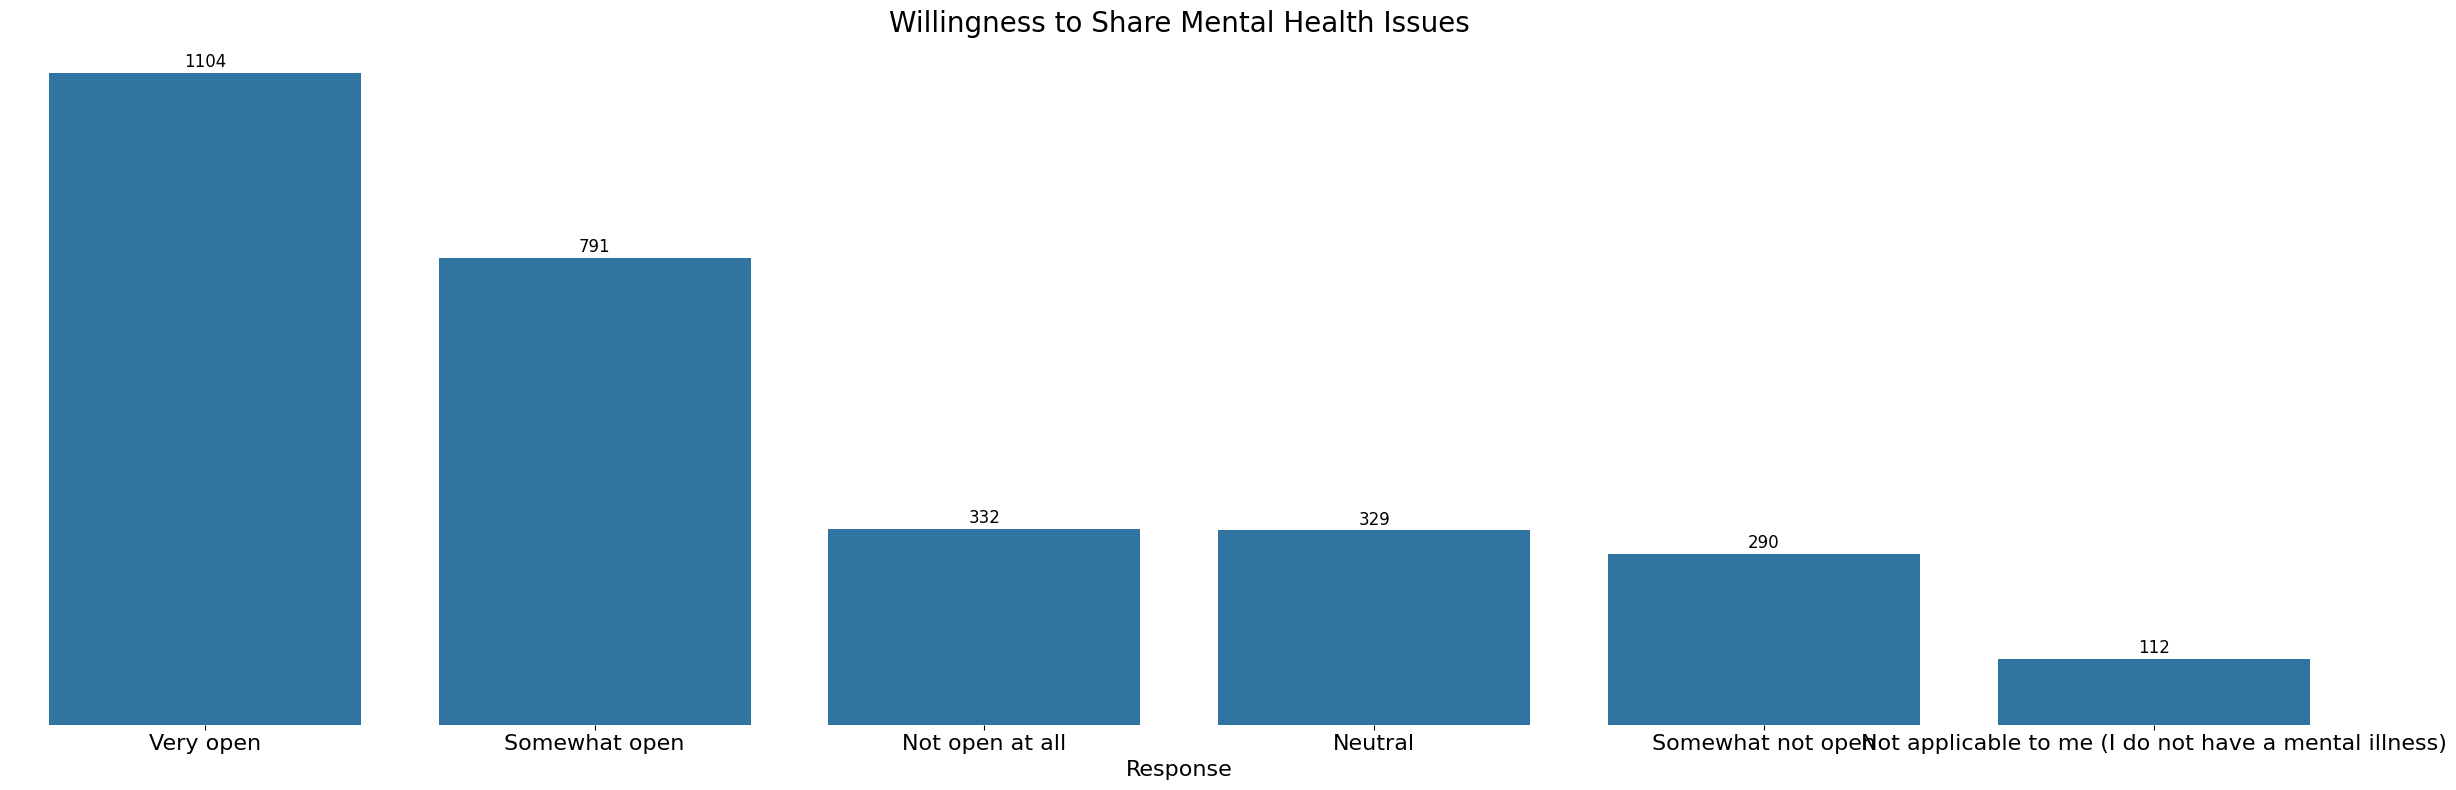

In [16]:
sharing_willingness = df[df['QuestionText'].str.contains('willing.*share.*friends.*family', case=False, na=False)]

sharing_counts = sharing_willingness['AnswerText'].value_counts()

plt.figure(figsize=(25, 8))
ax = sns.barplot(x=sharing_counts.index, y=sharing_counts.values)
for i, v in enumerate(sharing_counts.values):
    ax.text(i, v + 10, str(v), ha='center', fontsize=12)

plt.title("Willingness to Share Mental Health Issues", fontsize=20)
plt.xlabel("Response", fontsize=16)
plt.ylabel("Count", fontsize=16)
plt.gca().axes.yaxis.set_visible(False)
plt.xticks(fontsize=16)
plt.yticks(fontsize=14)
sns.despine(left=True, bottom=True)
plt.tight_layout()
plt.show()


A lot of people with mental health issues are willing to share their experiences and struggles with mental health. 

This is a good sign as through this the community around them can best evaluate how to accomodate them and support them in any possible ways to make it manageable

## Mental Health in the Work place over the years

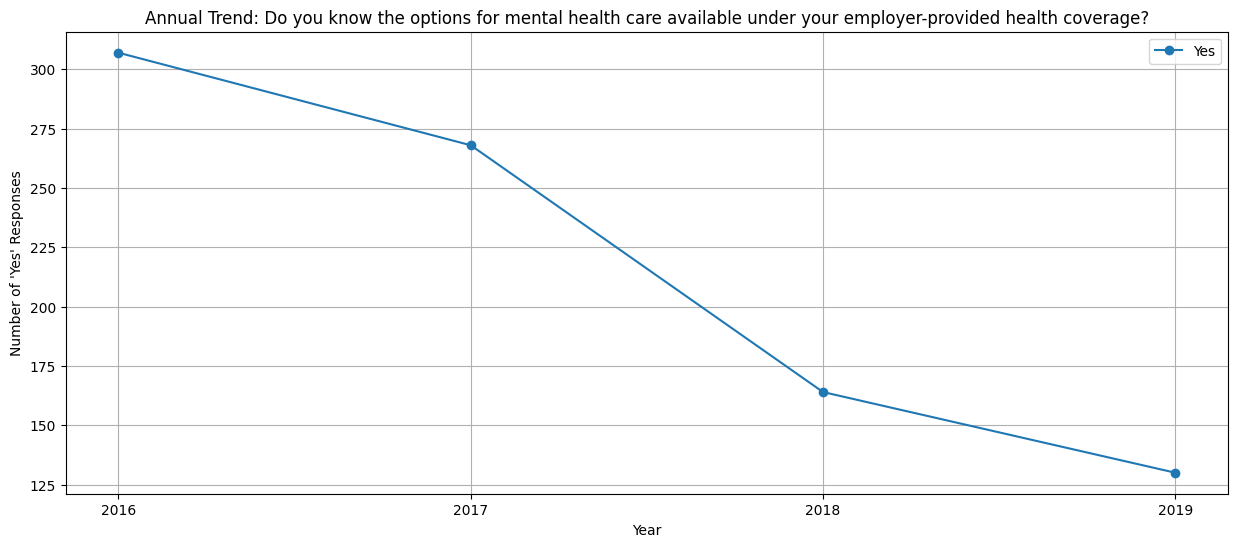

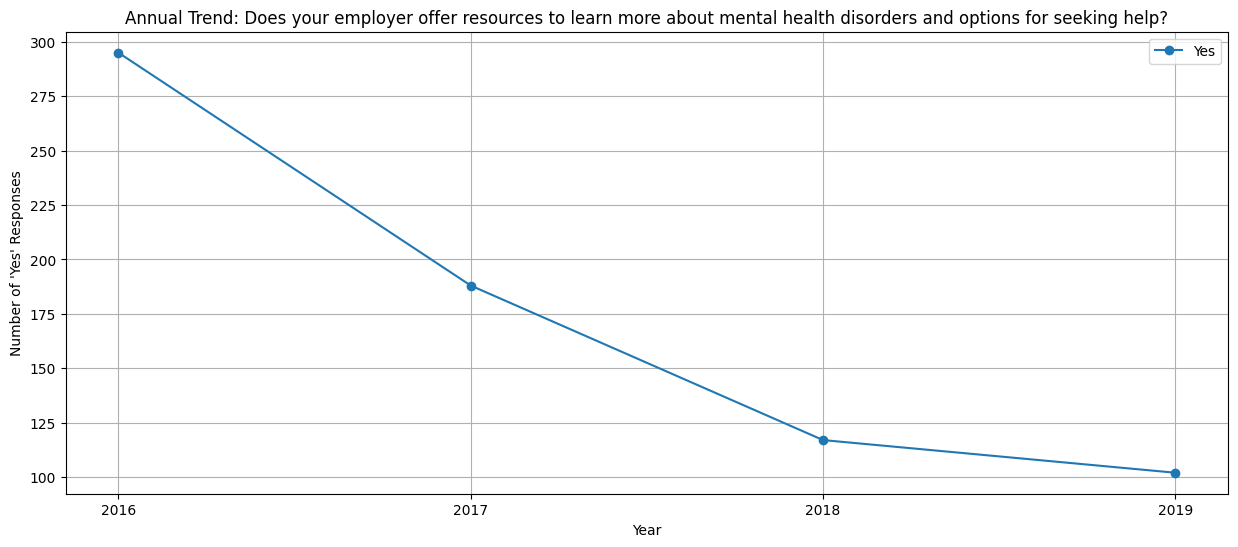

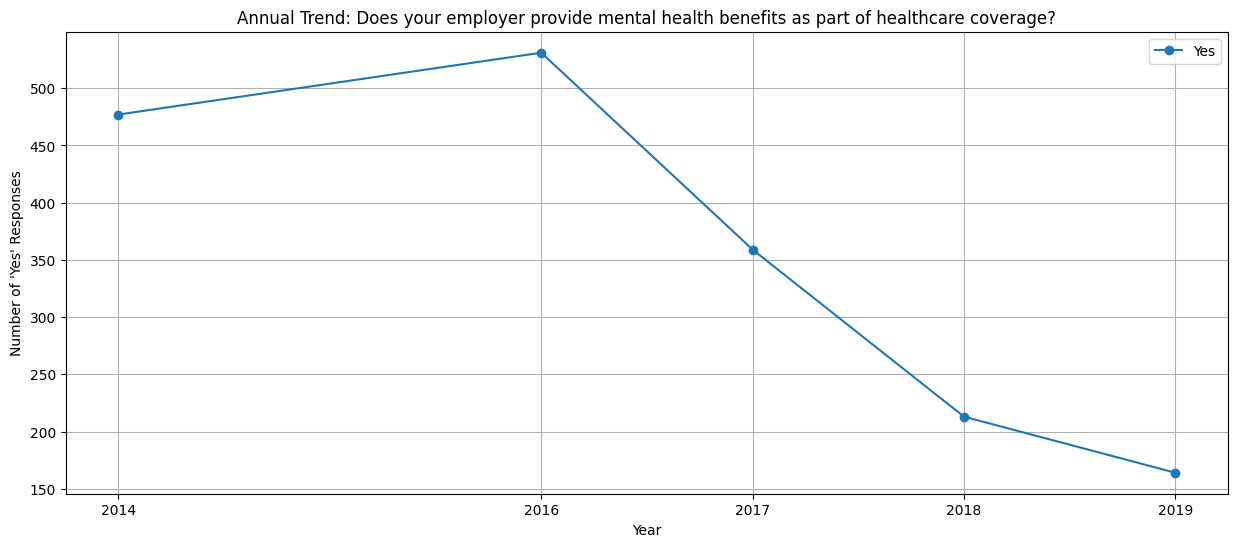

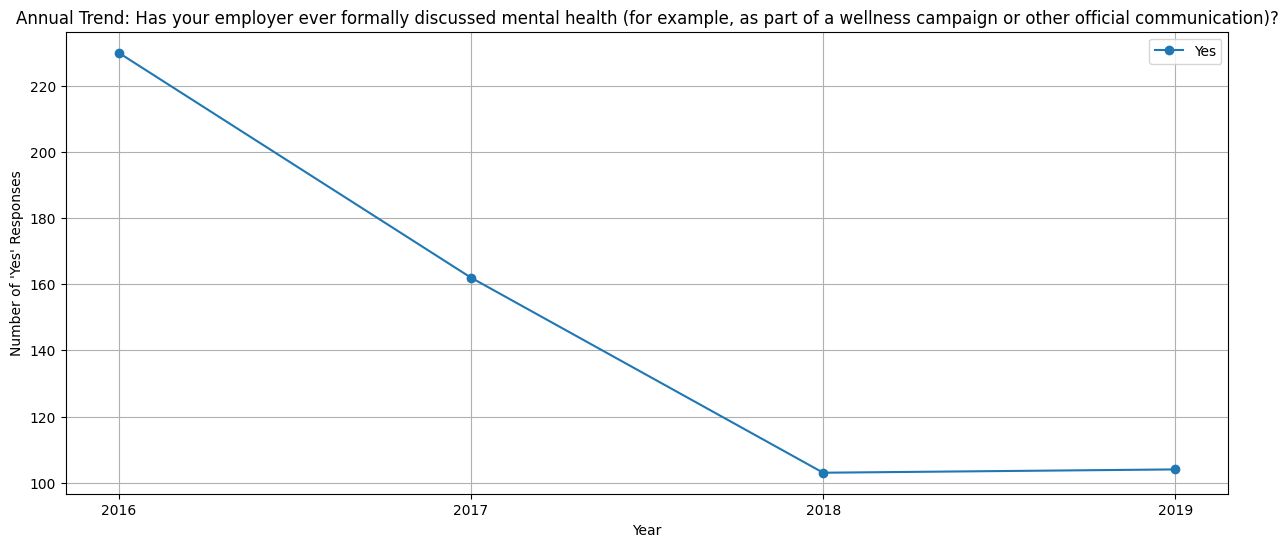

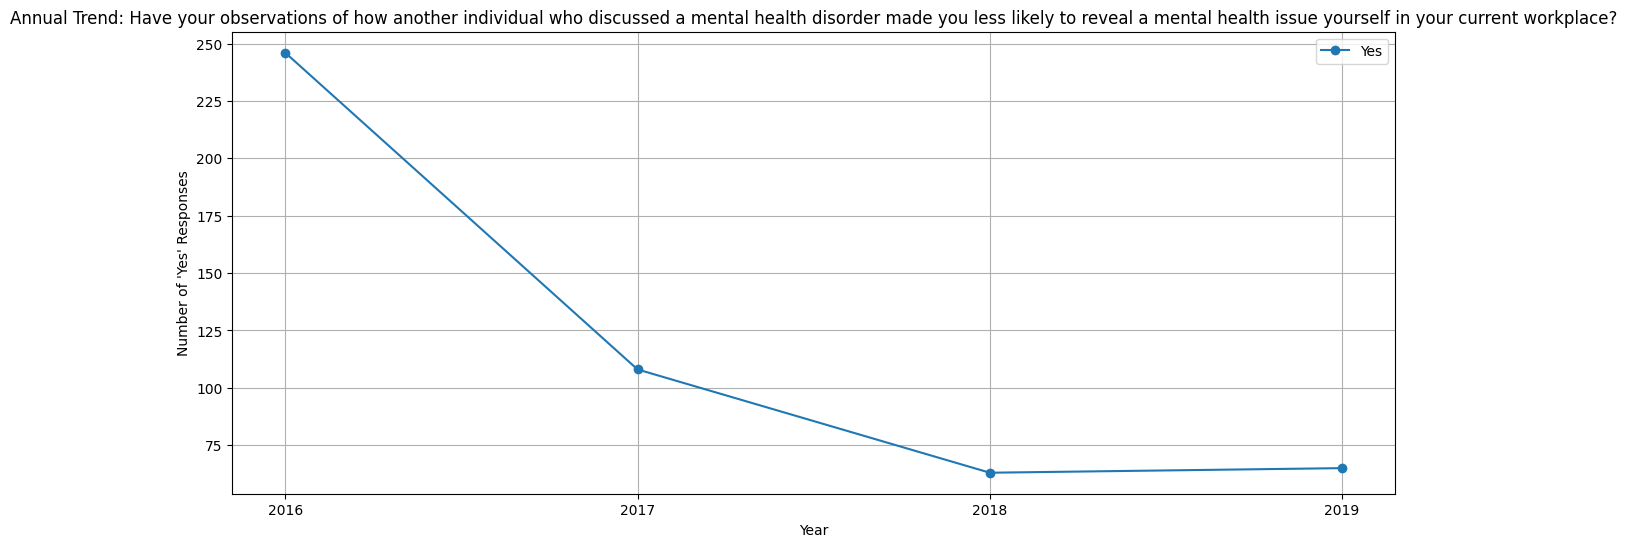

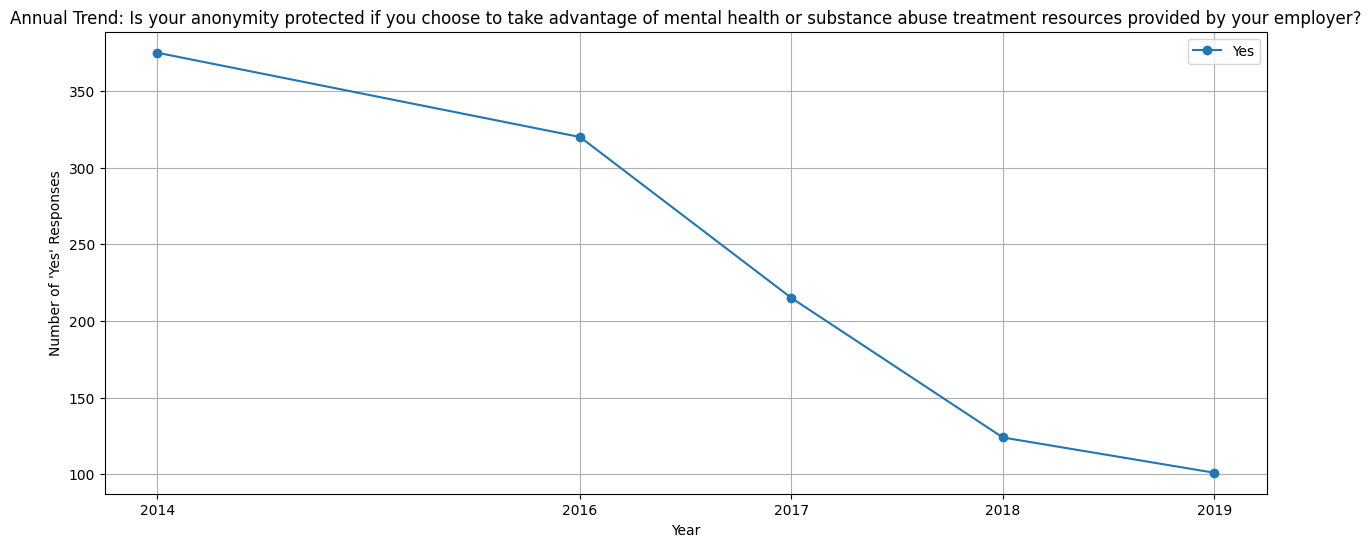

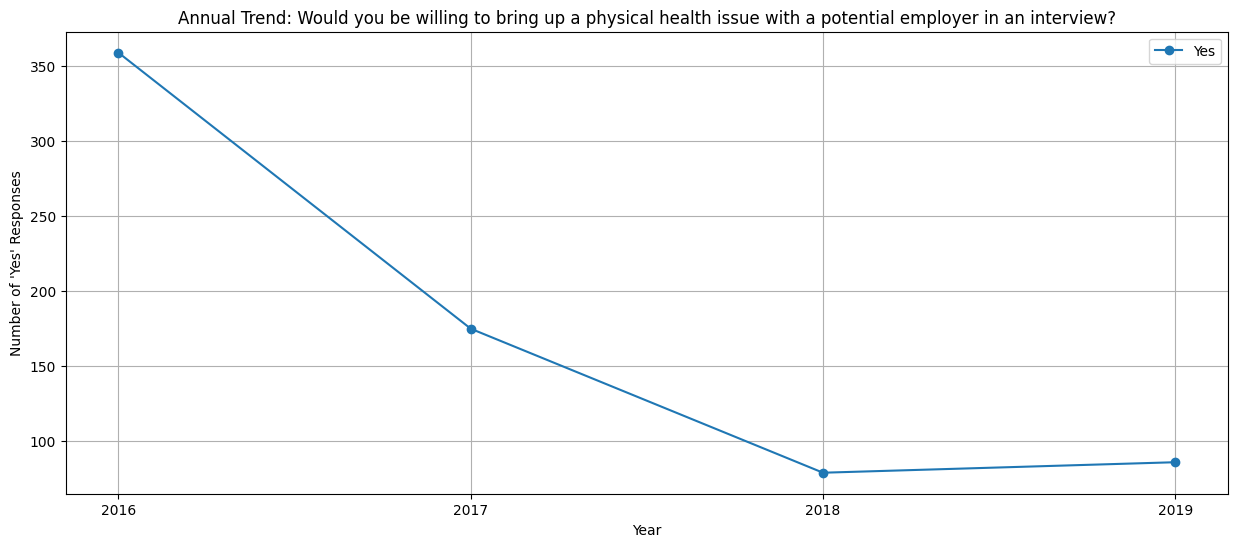

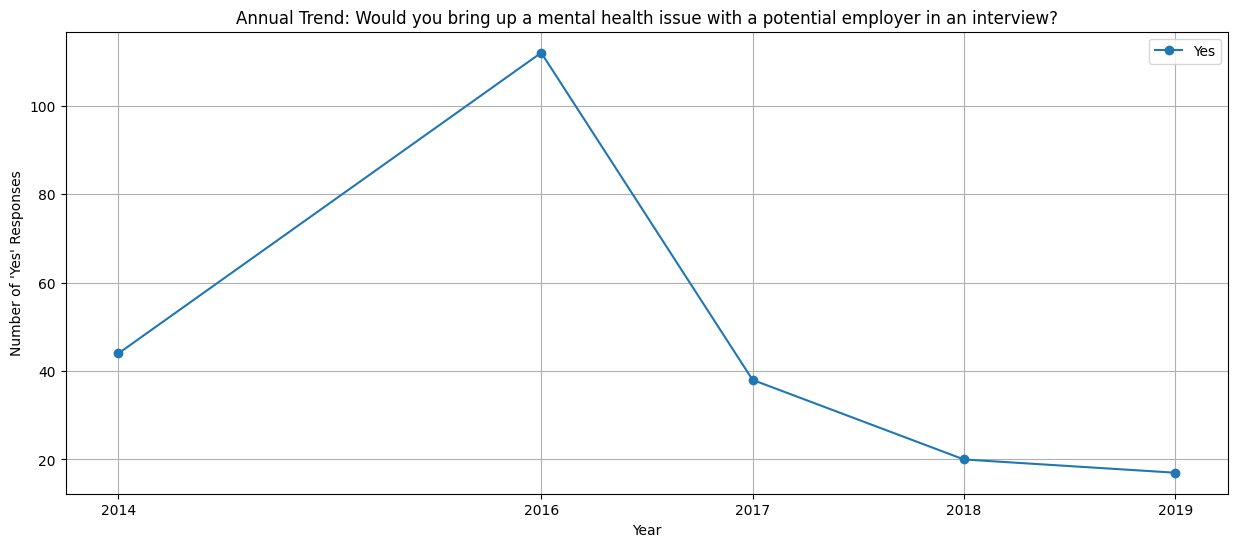

In [17]:
df['Year'] = df['SurveyID']

workplace_questions = df[df['QuestionText'].str.contains('employer|workplace', case=False, na=False)]

question_year_yes_counts = workplace_questions[workplace_questions['AnswerText'] == 'Yes'].groupby(
    ['QuestionText', 'Year']
)['AnswerText'].count().unstack(fill_value=0)

# Filter questions with "Yes" responses in more than 2 years for annual trend analysis
valid_questions = question_year_yes_counts[(question_year_yes_counts > 0).sum(axis=1) > 2]

valid_workplace_data = workplace_questions[workplace_questions['QuestionText'].isin(valid_questions.index)]

workplace_annual_stats = valid_workplace_data.groupby(
    ['Year', 'QuestionText', 'AnswerText']
).size().unstack(fill_value=0)

for question in valid_questions.index:
    question_data = workplace_annual_stats.loc[(slice(None), question), :]
    question_data = question_data.reset_index(level=1, drop=True)

    plt.figure(figsize=(15, 6))
    plt.plot(question_data.index, question_data['Yes'], marker='o', label="Yes")
    plt.title(f"Annual Trend: {question}")
    plt.xlabel("Year")
    plt.ylabel("Number of 'Yes' Responses")
    plt.xticks(question_data.index)
    plt.legend()
    plt.grid(True)
    plt.show()


There is generally a down trend in awareness and accomodation for mental health issues in the work place and employers seem to be investing less in the effort.

This is a rather concerning trend as it shows that in the near future, there could almost be no room for people witrh mental health in the IT work place. This is heavily consequential as it can affect the growth of the sector as it might deter prospective talents or even willing upskilling employees from joing the sector.

## Prominent Mental Health Issues


Most Common Mental Health Conditions:
[('depression', 1058), ('anxiety', 923), ('bipolar', 663), ('stress', 372), ('adhd', 243), ('ptsd', 127), ('ocd', 13), ('insomnia', 3)]


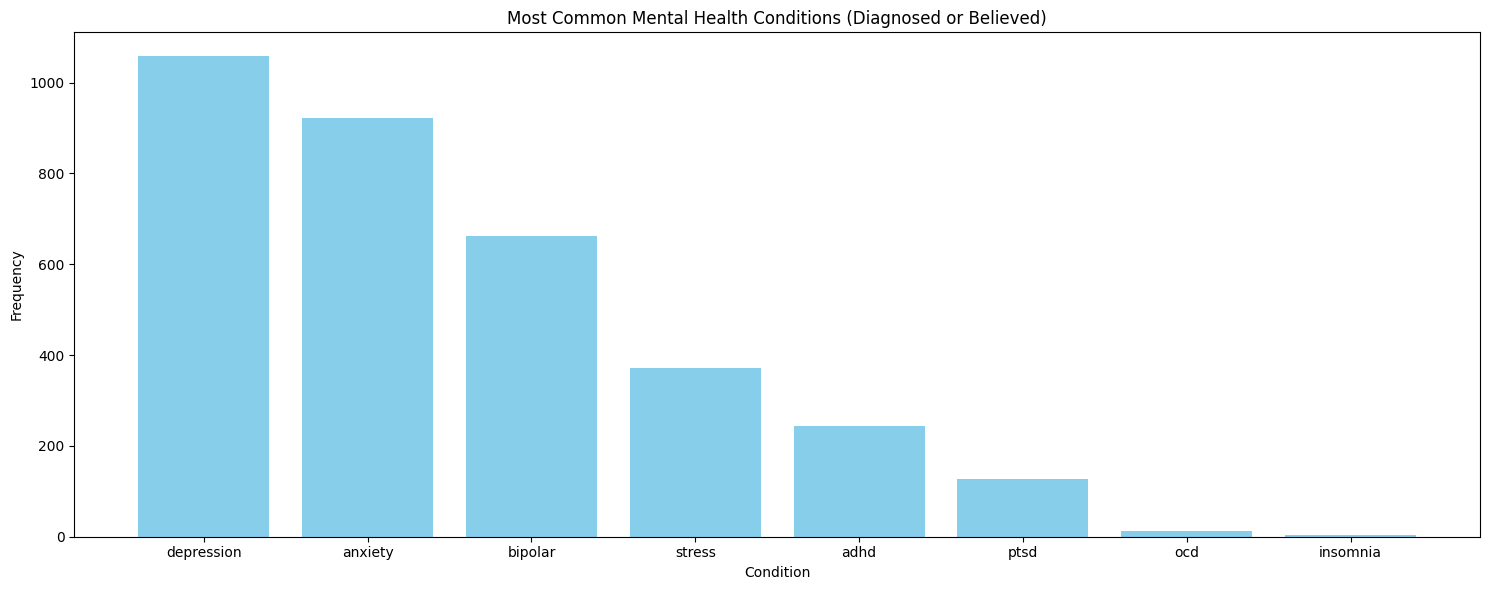

In [18]:
condition_questions = df.loc[df['QuestionID'].isin([115, 116, 75, 71, 74, 73, 63, 59, 61, 82, 88, 84]), :].copy()

disorder_mapping = {
    'anxiety': ['anxiety', 'anxiety disorder', 'generalized anxiety'],
    'depression': ['depression', 'depressive disorder', 'major depression'],
    'stress': ['stress', 'chronic stress'],
    'ptsd': ['ptsd', 'post-traumatic stress disorder'],
    'bipolar': ['bipolar', 'bipolar disorder'],
    'ocd': ['ocd', 'obsessive compulsive disorder'],
    'adhd': ['adhd', 'attention deficit hyperactivity disorder'],
    'insomnia': ['insomnia', 'sleep disorder']
}

def extract_conditions(response):
    if pd.isnull(response):
        return []  # Handle NaN responses
    response = response.lower()
    matched_conditions = []
    for condition, keywords in disorder_mapping.items():
        if any(keyword in response for keyword in keywords):
            matched_conditions.append(condition)
    return matched_conditions


condition_questions['ExtractedConditions'] = condition_questions['AnswerText'].apply(extract_conditions)


all_conditions = [condition for conditions in condition_questions['ExtractedConditions'] for condition in conditions]
condition_counts = Counter(all_conditions)

# Handle and display results
if not condition_counts:
    print("No conditions found in the responses.")
else:
    most_common_conditions = condition_counts.most_common(10)
    print("Most Common Mental Health Conditions:")
    print(most_common_conditions)

    # Extract condition names and counts for visualization
    conditions, counts = zip(*most_common_conditions)
    plt.figure(figsize=(15, 6))
    plt.bar(conditions, counts, color='skyblue')
    plt.title("Most Common Mental Health Conditions (Diagnosed or Believed)")
    plt.xlabel("Condition")
    plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()


### Annual distribution of Mental Health Issues according to survey

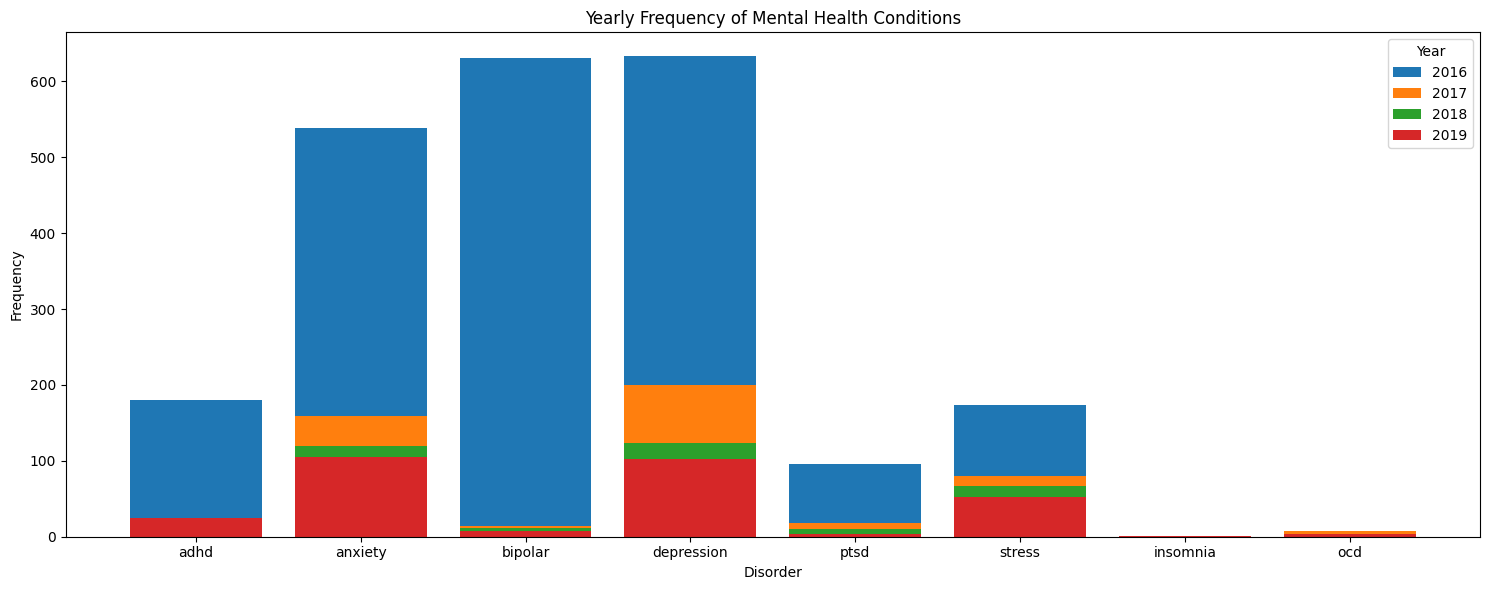

In [19]:
condition_questions.loc[:, 'Year'] = condition_questions['SurveyID']

expanded_conditions = condition_questions.explode('ExtractedConditions')

yearly_condition_counts = expanded_conditions.groupby(['Year', 'ExtractedConditions']).size().reset_index(name='Count')

most_common_by_year = yearly_condition_counts.loc[
    yearly_condition_counts.groupby('Year')['Count'].idxmax()
]

plt.figure(figsize=(15, 6))
for year in most_common_by_year['Year']:
    yearly_data = yearly_condition_counts[yearly_condition_counts['Year'] == year]
    plt.bar(yearly_data['ExtractedConditions'], yearly_data['Count'], label=f'{int(year)}')

plt.title("Yearly Frequency of Mental Health Conditions")
plt.xlabel("Disorder")
plt.ylabel("Frequency")
plt.legend(title='Year')
plt.tight_layout()
plt.show()


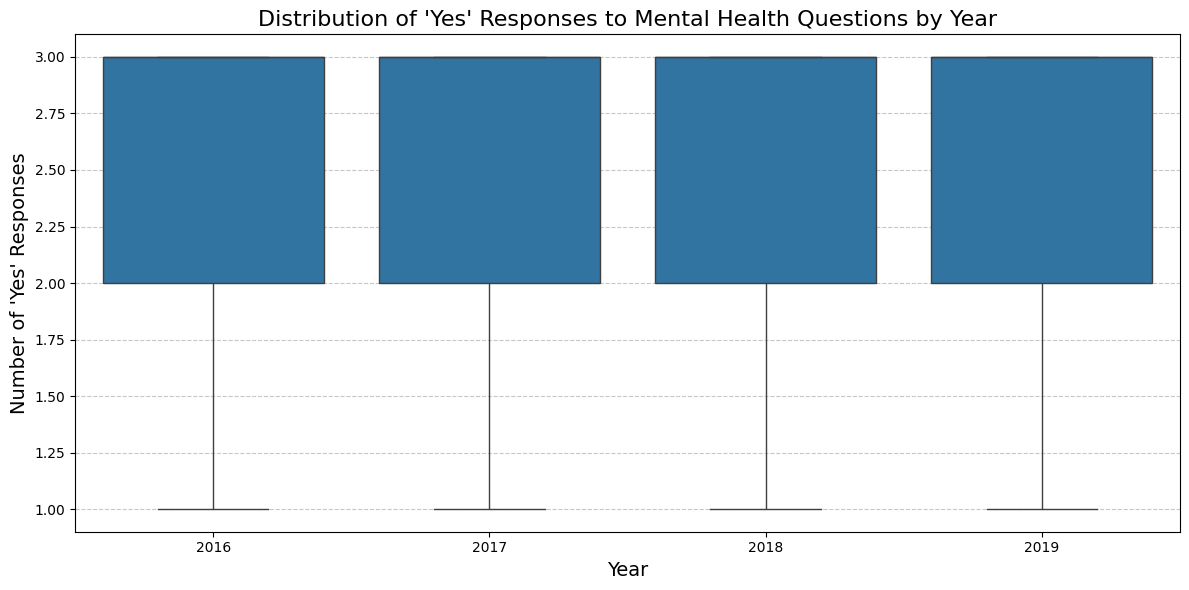

In [20]:
# relevant QuestionIDs
mental_health_questions = df[df['QuestionID'].isin([7, 32, 33, 34, 78])]

yes_responses = mental_health_questions[mental_health_questions['AnswerText'].str.strip().str.lower() == 'yes']

if 'Year' not in yes_responses.columns:
    yes_responses['Year'] = yes_responses['SurveyID']

yes_counts_by_year = yes_responses.groupby(['Year', 'UserID']).size().reset_index(name='Yes_Count')

plt.figure(figsize=(12, 6))
sns.boxplot(data=yes_counts_by_year, x='Year', y='Yes_Count')
plt.title("Distribution of 'Yes' Responses to Mental Health Questions by Year", fontsize=16)
plt.xlabel("Year", fontsize=14)
plt.ylabel("Number of 'Yes' Responses", fontsize=14)
plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.tight_layout()
plt.show()


## Final Insights and Recommendations

The survey does a great job to cover vast grounds so as to offer insight into mental health in the tech industry, it is however faulty in major ways that might affect a better understanding of the issue. It is heavily biased in many areas and metrics along which the survey was conducted and this limits how well it illustrates the actual ways in which, and who is, affected by mental health issues. 

We do notice a general downward trend leading up to 2019 in the awareness, resource availability and work place accomodation for mental health issues and pratices to help avert them. 

I would reccomend that employers in tech companies avail more resources to assist and ensure well being of workers with mental health. As an industry that can operate well on a large scale virtual model, it is easy for workers to have to suffer in silence and not get help. This affects not just productivity but would also drive uo employee turnover making it costly to maintain a functional work force.